In [1]:
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt
from numba import jit
from tqdm import tqdm
from itertools import combinations, permutations
import time

In [2]:
data_C = np.loadtxt('../data/TSPC.csv', delimiter=';').astype(np.int64)
data_D = np.loadtxt('../data/TSPD.csv', delimiter=';').astype(np.int64)

In [3]:
def create_cost_matrix(data):
    x = data[:, :1]
    y = data[:, 1:2]
    cost = data[:, 2:3]
    return (((x - x.reshape(1, -1))**2 + (y - y.reshape(1, -1))**2) ** (1/2) + cost.reshape(1, -1)).round().astype(np.int64)

def create_dist_matrix(data):
    x = data[:, :1]
    y = data[:, 1:2]
    #cost = data[:, 2:3]
    return (((x - x.reshape(1, -1))**2 + (y - y.reshape(1, -1))**2) ** (1/2)).round().astype(np.int64)

In [4]:
cost_matrix_C = create_cost_matrix(data_C)

In [5]:
cost_matrix_D = create_cost_matrix(data_D)

In [6]:
dist_matrix_C = create_dist_matrix(data_C)
dist_matrix_D = create_dist_matrix(data_D)

In [7]:
def plot(data, solution):
    data_ordered = np.array([data[i] for i in solution])
    all_data = np.array([data[i] for i in range(200)])

    plt.figure(figsize=(10, 10), dpi=80)

    plt.scatter(data_ordered[:,0], data_ordered[:,1], s=data_ordered[:,2]/data_ordered[:,2].max()*200, c='b')
    plt.scatter(all_data[:,0], all_data[:,1], s=all_data[:,2]/all_data[:,2].max()*200, c='b')
    plt.plot(data_ordered[:,0], data_ordered[:,1], 'y-')
    plt.plot([data_ordered[0,0], data_ordered[-1,0]], [data_ordered[0,1], data_ordered[-1,1]], 'y-')
    plt.show()

In [8]:
def calculate_performance(cycle, cost_matrix):
    total_sum = 0
    for i in range(len(cycle)-1):
        total_sum += cost_matrix[cycle[i], cycle[i+1]]
    total_sum += cost_matrix[cycle[-1], cycle[0]]
    return total_sum

In [9]:
#@jit()
def random_solution(cost_matrix, limit=100):
    random_solution_list = list(range(0,len(cost_matrix)))
    random.shuffle(random_solution_list)
    return np.array(random_solution_list)[:limit]

solution = random_solution(cost_matrix_C, 100)
print(solution)

[101 173 125 153  85  57  72   6 162  21  61 152  63  23 192 176 127 121
 124 151  89  32 168   5 195 197 135 171 158 182  56 113 111 196 123 116
  50  16 100  54 161 129 154   7 112  13   0 142 108 138 134   8 149 163
  26 175  11 145 183  38 146  58  80  82 117 194 189 144  48  67 137  44
 166  19 143   9  65 188  10  43  79  30 136  12 174  93  36 172 115  83
  95 191  71  27 165  35 103 110 131  91]


In [18]:
#@jit()
def greedy_cycle(cost_matrix, current_id, limit=100):
    all_ids = set(list(range(0,len(cost_matrix))))
    all_ids.remove(current_id)
    solution = [current_id]
    
    for _ in range(1):
        min_val = 99999
        min_id = -1
        for next_id in all_ids:
            if cost_matrix[current_id][next_id] < min_val:
                min_val = cost_matrix[current_id][next_id]
                min_id = next_id
        solution.append(min_id)
        all_ids.remove(min_id)
        current_id = min_id
    
    while len(solution) < limit:
        min_delta = 99999
        min_id = -1
        insert_id = -1
        for i in range(len(solution)-1):
            for next_id in all_ids:
                delta = cost_matrix[solution[i]][next_id] + cost_matrix[next_id][solution[i+1]] - cost_matrix[solution[i]][solution[i+1]]
                if delta < min_delta:
                    min_delta = delta
                    min_id = next_id
                    insert_id = i
        for next_id in all_ids:
            delta = cost_matrix[solution[-1]][next_id] + cost_matrix[next_id][solution[0]] - cost_matrix[solution[-1]][solution[0]]
            if delta < min_delta:
                min_delta = delta
                min_id = next_id
                insert_id = i
        solution.insert(insert_id+1, min_id)
        all_ids.remove(min_id)

    return np.array(solution)

In [19]:
# swap node in cycle and unused node
def inter_exchange_delta(cycle, cost_matrix, used_cycle_id, unused_node):
    if used_cycle_id == len(cycle)-1:
        return cost_matrix[cycle[used_cycle_id-1], unused_node] + cost_matrix[unused_node, cycle[0]] - cost_matrix[cycle[used_cycle_id-1], cycle[used_cycle_id]] - cost_matrix[cycle[used_cycle_id], cycle[0]]
    return cost_matrix[cycle[used_cycle_id-1], unused_node] + cost_matrix[unused_node, cycle[used_cycle_id+1]] - cost_matrix[cycle[used_cycle_id-1], cycle[used_cycle_id]] - cost_matrix[cycle[used_cycle_id], cycle[used_cycle_id+1]]

In [20]:
def intra_two_nodes_exchange_delta(cycle, cost_matrix, node1, node2, pri = False):
    # print(node1, node2)
    if node1 == len(cycle)-1:
        node1plus = 0
    else:
        node1plus = node1 + 1
    
    if node2 == len(cycle)-1:
        node2plus = 0
    else:
        node2plus = node2 + 1

    if abs(node1-node2) == 1:
        if node1 > node2:
            node1, node2 = node2, node1
            node1plus, node2plus = node2plus, node1plus
        return cost_matrix[cycle[node1-1], cycle[node2]] + cost_matrix[cycle[node2], cycle[node1]] + cost_matrix[cycle[node1], cycle[node2plus]] - cost_matrix[cycle[node1-1], cycle[node1]] - cost_matrix[cycle[node1], cycle[node2]] - cost_matrix[cycle[node2], cycle[node2plus]]
    if abs(node1-node2) == len(cycle)-1:
        if node1 < node2:
            node1, node2 = node2, node1
            node1plus, node2plus = node2plus, node1plus
        return cost_matrix[cycle[node1-1], cycle[node2]] + cost_matrix[cycle[node2], cycle[node1]] + cost_matrix[cycle[node1], cycle[node2plus]] - cost_matrix[cycle[node1-1], cycle[node1]] - cost_matrix[cycle[node1], cycle[node2]] - cost_matrix[cycle[node2], cycle[node2plus]]

    return cost_matrix[cycle[node1-1], cycle[node2]] + cost_matrix[cycle[node2], cycle[node1plus]] + cost_matrix[cycle[node2-1], cycle[node1]] + cost_matrix[cycle[node1], cycle[node2plus]] - cost_matrix[cycle[node1-1], cycle[node1]] - cost_matrix[cycle[node1], cycle[node1plus]] - cost_matrix[cycle[node2-1], cycle[node2]] - cost_matrix[cycle[node2], cycle[node2plus]]

In [21]:
def intra_two_edges_exchange_delta(cycle, dist_matrix, node1, node2):
    if node1 == len(cycle)-1 or node2 == len(cycle)-1:
        return 99999
    #print(cost_matrix[cycle[node1], cycle[node2]], cost_matrix[cycle[node1+1], cycle[node2+1]], cost_matrix[cycle[node1], cycle[node1+1]], cost_matrix[cycle[node2], cycle[node2+1]])
    return dist_matrix[cycle[node1], cycle[node2]] + dist_matrix[cycle[node1+1], cycle[node2+1]] - dist_matrix[cycle[node1], cycle[node1+1]] - dist_matrix[cycle[node2], cycle[node2+1]]


In [22]:
#jit()
def steepest_local_search(cost_matrix, dist_matrix, nodes_exchange = True, initial_greedy = False, starting_node = None, cycle = None):
    if cycle is None:
        if initial_greedy:
            if starting_node:
                cycle = greedy_cycle(cost_matrix, starting_node)
            else:
                cycle = greedy_cycle(cost_matrix, random.randint(0, len(cost_matrix)-1))
        else:
            cycle = random_solution(cost_matrix)
    unused_nodes = set(list(range(0,len(cost_matrix))))
    for node in cycle:
        unused_nodes.remove(node)

    all_combinations = list(combinations(list(range(0, 100)), 2))

    while(True):
        best_delta, swap_node_a, swap_node_b, best_type = 0, None, None, None
        for used_cycle_id in range(len(cycle)):
            for unused_node in unused_nodes:
                delta = inter_exchange_delta(cycle, cost_matrix, used_cycle_id, unused_node)
                if delta < best_delta:
                    best_delta, swap_node_a, swap_node_b, best_type = delta, used_cycle_id, unused_node, 'inter_exchange'
        if nodes_exchange:
            for x, y in all_combinations:
                delta = intra_two_nodes_exchange_delta(cycle, cost_matrix, x, y)
                if delta < best_delta:
                    best_delta, swap_node_a, swap_node_b, best_type = delta, x, y, 'intra_two_nodes_exchange'
        else:
            for x, y in all_combinations:
                delta = intra_two_edges_exchange_delta(cycle, dist_matrix, x, y)
                if delta < best_delta:
                    best_delta, swap_node_a, swap_node_b, best_type = delta, x, y, 'intra_two_edges_exchange'

        if best_type is not None:
            if best_type == 'inter_exchange':
                unused_nodes.add(cycle[swap_node_a])
                unused_nodes.remove(swap_node_b)
                cycle[swap_node_a] = swap_node_b
            elif best_type == 'intra_two_nodes_exchange':
                cycle[swap_node_a], cycle[swap_node_b] = cycle[swap_node_b], cycle[swap_node_a]
            elif best_type == 'intra_two_edges_exchange':
                cycle[swap_node_a+1], cycle[swap_node_b] = cycle[swap_node_b], cycle[swap_node_a+1]
                cycle[swap_node_a+2:swap_node_b] = cycle[swap_node_a+2:swap_node_b][::-1]
        else:
            break
    return cycle

In [23]:
#jit()
def greedy_local_search(cost_matrix, dist_matrix, nodes_exchange = True, initial_greedy = False, starting_node = None, cycle = None):
    if cycle is None:
        if initial_greedy:
            if starting_node:
                cycle = greedy_cycle(cost_matrix, starting_node)
            else:
                cycle = greedy_cycle(cost_matrix, random.randint(0, len(cost_matrix)-1))
        else:
            cycle = random_solution(cost_matrix)
    unused_nodes = set(list(range(0,len(cost_matrix))))
    for node in cycle:
        unused_nodes.remove(node)

    #neighbourhood = [(x, y, 'inter') for x in range(len(cycle)) for y in unused_nodes]
    #neighbourhood += [(x, y, 'intra') for x, y in combinations(list(range(0, 100)), 2)]

    while(True):
        best_delta, swap_node_a, swap_node_b, best_type = 0, None, None, None
        neighbourhood = [(x, y, 'inter') for x in range(len(cycle)) for y in unused_nodes]
        neighbourhood += [(x, y, 'intra') for x, y in combinations(list(range(0, 100)), 2)]
        random.shuffle(neighbourhood)
        if nodes_exchange:
            for x, y, z in neighbourhood:
                if z == 'inter':
                    delta = inter_exchange_delta(cycle, cost_matrix, x, y)
                    if delta < best_delta:
                        best_delta, swap_node_a, swap_node_b, best_type = delta, x, y, 'inter_exchange'
                        break
                elif z == 'intra':
                    delta = intra_two_nodes_exchange_delta(cycle, cost_matrix, x, y)
                    if delta < best_delta:
                        best_delta, swap_node_a, swap_node_b, best_type = delta, x, y, 'intra_two_nodes_exchange'
                        break
        else:
            for x, y, z in neighbourhood:
                if z == 'inter':
                    delta = inter_exchange_delta(cycle, cost_matrix, x, y)
                    if delta < best_delta:
                        best_delta, swap_node_a, swap_node_b, best_type = delta, x, y, 'inter_exchange'
                        break
                elif z == 'intra':
                    delta = intra_two_edges_exchange_delta(cycle, dist_matrix, x, y)
                    if delta < best_delta:
                        best_delta, swap_node_a, swap_node_b, best_type = delta, x, y, 'intra_two_edges_exchange'
                        break

        if best_type is not None:
            if best_type == 'inter_exchange':
                unused_nodes.add(cycle[swap_node_a])
                unused_nodes.remove(swap_node_b)
                cycle[swap_node_a] = swap_node_b
                #neighbourhood = [(x, y) for x in range(len(cycle)) for y in unused_nodes]
            elif best_type == 'intra_two_nodes_exchange':
                cycle[swap_node_a], cycle[swap_node_b] = cycle[swap_node_b], cycle[swap_node_a]
            elif best_type == 'intra_two_edges_exchange':
                cycle[swap_node_a+1], cycle[swap_node_b] = cycle[swap_node_b], cycle[swap_node_a+1]
                cycle[swap_node_a+2:swap_node_b] = cycle[swap_node_a+2:swap_node_b][::-1]
        else:
            break
    return cycle

In [24]:
def calculate_k_regret_newest(mat, bool_mask, k, solution, weighted=False):
    total = np.array(sorted(list(set(range(200)))), dtype=np.int64)
    anti_solution = np.array(sorted(list(set(range(200)) - set(solution))))
    
    new_mat = (mat[solution][:, anti_solution].T
    + np.c_[mat[anti_solution][:, solution][:, 1:], mat[anti_solution][:, solution][:, :1]]
    - np.append(np.diagonal(mat[solution][:, solution], 1), mat[solution][:, solution][-1:, :1]).reshape(1, -1))

    biggest_regret = 0 # what's yours? 
    id_biggest = None
    
    sorted_mat = np.sort(new_mat, axis=1)

    if weighted:
        regrets = (sorted_mat[:, 1:k] - sorted_mat[:, :1]).sum(axis=1) * (1 / sorted_mat[:, :1])
    else:
        regrets = (sorted_mat[:, 1:k] - sorted_mat[:, :1]).sum(axis=1)
    
    # print(regrets.shape, sorted_mat.shape)

    biggest_regret = regrets.max()
    
    id_biggest = np.where(regrets == biggest_regret)[0][0]
    
    new_node_id = total[anti_solution][id_biggest]
    node_to_append = total[solution][np.where(new_mat[id_biggest] == new_mat[id_biggest].min())[0]][0]
    
    
    return new_node_id, node_to_append, biggest_regret


def tsp_regret(cost_matrix, solution: list, max_nodes=100, k=2, weighted=True):
    # solution_set = set([starting_node])
    # solution = list([starting_node])
    solution_set = set(solution)

    ## regular greedy
    # total = np.array(sorted(list(set(range(200)))), dtype=np.int64)
    total = np.arange(200, dtype=np.int64)
    for i in range(k-1):
        previous_node = solution[-1]
        # bool_mask = pd.Series(range(len(cost_matrix))).isin(solution_set)
        
        # bool_mask = np.array(sorted(list(set(range(200)) - set(solution))))
        bool_mask = np.array(sorted(list(set(range(200)) - solution_set)))
        matrix_id = np.where(cost_matrix[previous_node][bool_mask] == cost_matrix[previous_node][bool_mask].min())[0][0]
        #print(total[bool_mask])
        new_node = total[bool_mask][matrix_id]
        solution_set.add(new_node)
        solution.append(new_node)
    
    ## tsp with regret
    while len(solution_set) < max_nodes:
        # bool_mask_solution_nodes = pd.Series(range(len(cost_matrix))).isin(solution_set)
        new_node_id, node_to_append, regret_value = calculate_k_regret_newest(cost_matrix, k, k, np.array(solution), weighted)
        solution.insert(solution.index(node_to_append)+1, new_node_id)
        solution_set.add(new_node_id)
        
    # solution.append(solution[0])

    return np.array(solution)

Tests

In [28]:
def plot(data, solution):
    data_ordered = np.array([data[i] for i in solution])
    all_data = np.array([data[i] for i in range(200)])

    plt.figure(figsize=(10, 10), dpi=80)

    plt.scatter(data_ordered[:,0], data_ordered[:,1], s=data_ordered[:,2]/data_ordered[:,2].max()*200, c='b')
    plt.scatter(all_data[:,0], all_data[:,1], s=all_data[:,2]/all_data[:,2].max()*200, c='b')
    plt.plot(data_ordered[:,0], data_ordered[:,1], 'y-')
    plt.plot([data_ordered[0,0], data_ordered[-1,0]], [data_ordered[0,1], data_ordered[-1,1]], 'y-')
    plt.show()

In [29]:
def present_results(min, max, average, time, iter, best_cycle):
    print("{: >10} {: >10} {: >10} {: >10} {: >10}".format('MIN', 'MAX', 'AVG', 'TIME', 'ITER'))
    print("{: >10} {: >10} {: >10} {: >10} {: >10}".format(min, max, average, time, iter))
    print()
    return best_cycle

In [ ]:
# implement a hybrid evolutionary algorithm
def hybrid_evolutionary_algorithm(cost_matrix, dist_matrix, local_search = True, stop_time = 150, population = None):
    start = time.time()
    # create initial population
    if population is None:
        population = []
        for _ in range(20):
            cycle = random_solution(cost_matrix)
            cycle = steepest_local_search(cost_matrix, dist_matrix, nodes_exchange = False, cycle=cycle)
            population.append(cycle)
    population = np.array(population)
    # evaluate initial population
    population_cost = []
    for cycle in population:
        population_cost.append(calculate_performance(cycle, cost_matrix))

    # sort population by cost
    population = np.array([x for _,x in sorted(zip(population_cost, population))])
    population_cost = sorted(population_cost)
    nr_iter = 0
    while (time.time() - start) < stop_time:
        nr_iter += 1
        # Draw at random two different solutions (parents) using uniform distribution
        parent1, parent2 = population[np.random.choice(population.shape[0], 2, replace=False), :]
        # Construct an offspring solution by recombining parents
        cycle = recombination(cost_matrix, parent1, parent2)
        # apply local search
        if local_search:
            cycle = steepest_local_search(cost_matrix, dist_matrix, nodes_exchange = False, cycle=cycle)
        # if child is better than worst solution, replace worst solution with child
        cycle_cost = calculate_performance(cycle, cost_matrix)
        if cycle_cost < population_cost[-1] and cycle_cost not in population_cost:
            population[-1] = cycle
            population_cost[-1] = cycle_cost
            # sort population by cost
            population = np.array([x for _,x in sorted(zip(population_cost, population))])
            population_cost = sorted(population_cost)
       
    # return best solution
    return population[0], nr_iter

# implement a recombination operator
def recombination(cost_matrix, parent1, parent2):
    parent1_copy = parent1.copy()
    parent2_copy = parent2.copy()
    # remove from parent1 all edges and nodes that are not present in the parent2
    for i in range(len(parent1_copy)):
        if parent1_copy[i] not in parent2_copy:
            parent1_copy[i] = -1
    # remove all -1 from parent1
    parent1_copy = [x for x in parent1_copy if x != -1]
    # repair
    new_cycle = tsp_regret(cost_matrix, list(parent1_copy))
    return new_cycle

In [36]:
hybrid_evolutionary_algorithm(cost_matrix_C, dist_matrix_C, local_search = True, stop_time=10)

(array([167, 186, 141, 144, 102,  87,  79, 194,  21,  76, 145,  55,  22,
         53, 117,  15, 108, 171,  81, 180,  32,  62, 155, 195,  36, 132,
        128, 118,  37,  25, 181, 113,  74, 163,  61,  71,  64, 185,  27,
        147,  96,  59, 143, 159,  34, 164, 178,  19,   0, 149,  50, 121,
         91, 114,   4,  77,  43, 192, 199,  41,   1, 177, 137, 174,  75,
        189, 109, 119, 130,  92, 152,  11, 160, 198, 106,  48,  26,   8,
        105, 110, 169,  95,  31,  73,  12,  94,  72, 190,  98, 156, 172,
          6,  66, 112,   5,  51, 135,  99,  60, 101]),
 0)

In [110]:
calculate_performance(hybrid_evolutionary_algorithm(cost_matrix_C, dist_matrix_C, local_search = True, stop_time=150), cost_matrix_C)

50268 53767 51513.45
47423 47775 47601.65


47423

In [111]:
calculate_performance(hybrid_evolutionary_algorithm(cost_matrix_C, dist_matrix_C, local_search = False), cost_matrix_C)

49340 54107 51832.05
48009 48286 48164.65


48009

In [22]:
population = []
for _ in range(20):
    cycle = random_solution(cost_matrix_C)
    cycle = steepest_local_search(cost_matrix_C, dist_matrix_C, nodes_exchange = False, cycle=cycle)
    population.append(cycle)
population = np.array(population)

In [23]:
len(population)

20

In [20]:
%load_ext line_profiler

In [27]:
%lprun -f hybrid_evolutionary_algorithm hybrid_evolutionary_algorithm(cost_matrix_C, dist_matrix_C, local_search = False, stop_time=150, population=population)

49579 53753 51997.6
48341 48934 48820.8


Timer unit: 1e-07 s

Total time: 145.755 s
File: C:\Users\hubra\AppData\Local\Temp\ipykernel_5344\3703091017.py
Function: hybrid_evolutionary_algorithm at line 2

Line #      Hits         Time  Per Hit   % Time  Line Contents
     2                                           def hybrid_evolutionary_algorithm(cost_matrix, dist_matrix, local_search = True, stop_time = 150, population = None):
     3         1         30.0     30.0      0.0      start = time.time()
     4                                               # create initial population
     5         1          5.0      5.0      0.0      if population is None:
     6                                                   population = []
     7                                                   for _ in range(20):
     8                                                       cycle = random_solution(cost_matrix)
     9                                                       cycle = steepest_local_search(cost_matrix, dist_matrix, nodes_exchan

# TEST

In [44]:
def test_solution_hybrid(cost_matrix, dist_matrix, local_search):
    start = time.time()
    costs = []
    iter = []
    best_cost = 9999999999
    best_cycle = None
    for _ in tqdm(range(20)):
        try:
            cycle, nr_iter = hybrid_evolutionary_algorithm(cost_matrix, dist_matrix, local_search = local_search, stop_time=150)
        except:
            continue
        total_cost = calculate_performance(cycle, cost_matrix)
        costs.append(total_cost)
        iter.append(nr_iter)
        if total_cost < best_cost:
            best_cost = total_cost
            best_cycle = cycle
    costs = np.array(costs)
    iter = np.array(iter)
    return costs.min(), costs.max(), costs.mean(), time.time() - start, iter.mean(), best_cycle

In [45]:
print('DATASET C')
print('LOCAL SEARCH')
best_cycle_C1 = present_results(*test_solution_hybrid(cost_matrix_C, dist_matrix_C, True))
print('NO LOCAL SEARCH')
best_cycle_C2 = present_results(*test_solution_hybrid(cost_matrix_C, dist_matrix_C, False))

DATASET C
LOCAL SEARCH


100%|██████████| 20/20 [50:00<00:00, 150.04s/it]


       MIN        MAX        AVG       TIME       ITER
     47656      50033    48801.8 3000.8302195072174    3564.75

NO LOCAL SEARCH


100%|██████████| 20/20 [50:00<00:00, 150.00s/it]

       MIN        MAX        AVG       TIME       ITER
     47999      50530    49293.1 3000.0476167201996   200083.2



In [46]:
print(best_cycle_C1)
print(best_cycle_C2)

[ 26  92  48 106  11 152 130 119 109 189  75   1 177  41 137 199 192  43
  77   4 114  91 121  50 149   0  69  19 178 164  40 128 159 143  59 147
 116  27  96 185  64  20  71  61 163  74 113 181  25 132  36  55 195  22
  18  53  62 108  15 117 171  81 154 102 144 141  87  79 194  21 170 186
 127  88 153 167 101  99 135  51   5 112 190  66   6 172 156  98  72  94
  12  73  31  80 124 123   8  95 169 139]
[  6  66 112  51 135  99 101 167  45 186 127  88 153 161  76 145  55  22
 117  15 108 171 157  21 194  79  87 141 144 154  81 180  32  62  53 195
  36 132  25 181 113  74 163 183  61  71  20  64 185  96  27 116 147  59
 143 159  37 128 164 178  19  35  69   0 149  50 121  91 114   4  77  43
 192 199  41 177   1  75 189 109 119 130 152  11 160 106  48  92  26   8
 169  95  31  89  94  72 190  98 156 172]


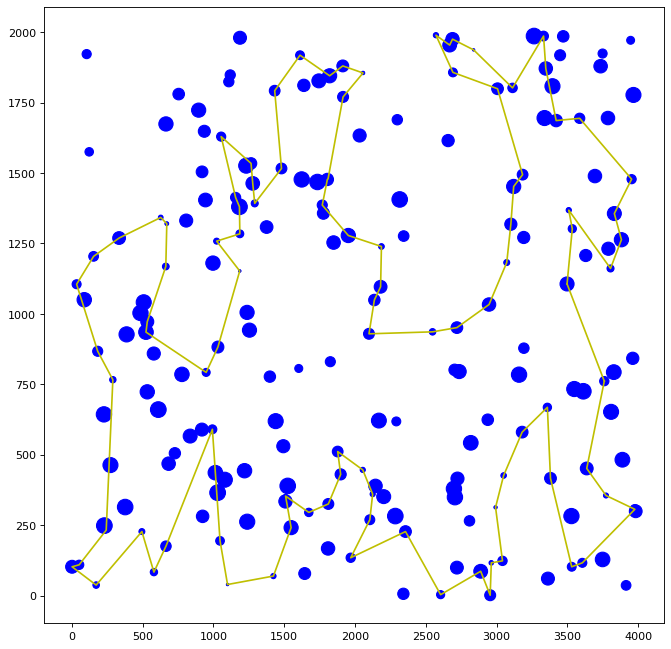

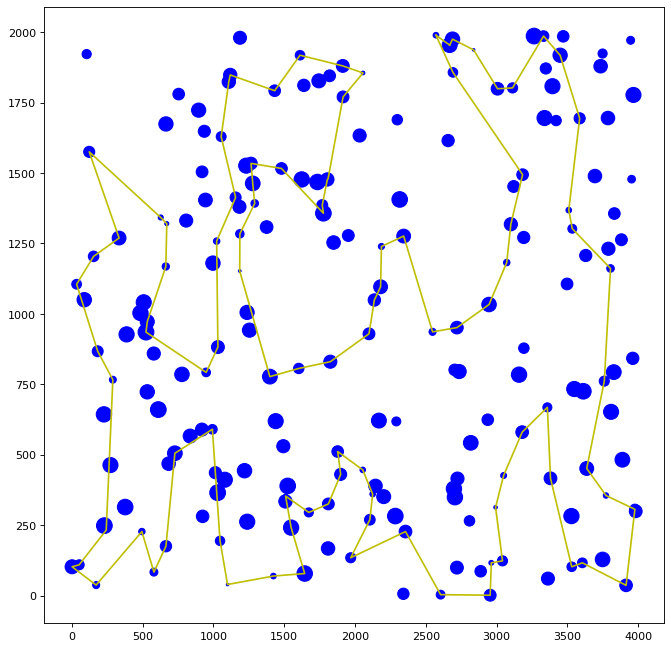

In [47]:
plot(data_C, best_cycle_C1)
plot(data_C, best_cycle_C2)

In [48]:
print('DATASET D')
print('LOCAL SEARCH')
best_cycle_D1 = present_results(*test_solution_hybrid(cost_matrix_D, dist_matrix_D, True))
print('NO LOCAL SEARCH')
best_cycle_D2 = present_results(*test_solution_hybrid(cost_matrix_D, dist_matrix_D, False))

DATASET D
LOCAL SEARCH


100%|██████████| 20/20 [50:00<00:00, 150.03s/it]


       MIN        MAX        AVG       TIME       ITER
     44368      46502    45524.6 3000.6231474876404    2965.45

NO LOCAL SEARCH


100%|██████████| 20/20 [50:00<00:00, 150.00s/it]

       MIN        MAX        AVG       TIME       ITER
     44365      48565   46071.45 3000.0486896038055  207452.65



In [51]:
print(best_cycle_D1)
print(best_cycle_D2)

[  5   2 182 163 115 113  69  82  63   8  16  52  12 107  97  59 119 193
  71  44 162 150 117 196 192  21 142 130 141 148 140 174  51  70  91 156
   3  67 158 114  85  72 171  58  89 129  64 159 147 181 189 132  18 185
  73  61 136  33  29  19 190 198 135  66 169   0  57  80 157 145 153   4
  55  88 137  37 165  36  25 134 154 102  99  50  24 127 121 131 103  38
 101  31 179 143 122  92 197 183  34 128]
[132 185  73  61 136  79 145 157  80 153   4  55  88 137  37 165  36  25
 134 154 112  50 131 103  38 101  31 121  24 127 179 143 122 197 183  34
  26  66 169   0  99  77  57 135 198 190  19  33  29  18  16   8  63 115
  82  53  21 192 142 130 141 148 140 174  51  70  91 156   3  67 114  72
 171  58  89 159 147  64 129  85 166 162 150 117 196  44  71 193 119  59
 181 170  47 189 109  12 107  97 139  52]


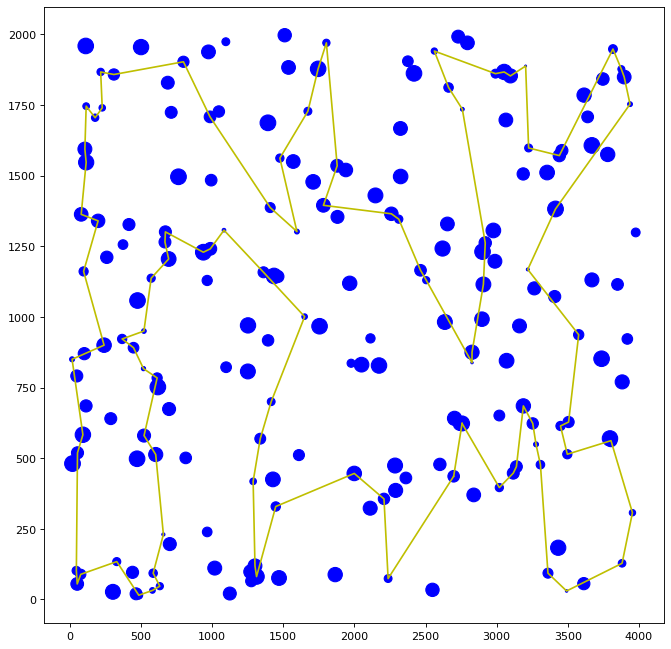

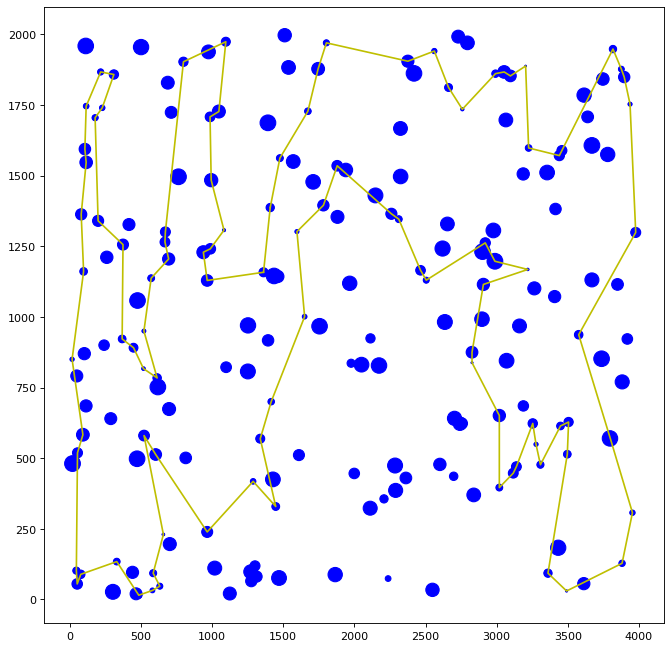

In [52]:
plot(data_D, best_cycle_D1)
plot(data_D, best_cycle_D2)